In [1]:
import pathlib
import warnings

import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline

import galstreams
from pyia import GaiaData
from astroquery.gaia import Gaia

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
data_path = pathlib.Path('../data/').resolve().absolute()
data_path.mkdir(exist_ok=True, parents=True)

In [3]:
streams = {
    #'GD-1': 'GD-1-PB18',
    #'Pal5': 'Pal5-PW19',
    #'Jhelum': 'Jhelum-b-B19',
    'Fjorm-M68': 'Fjorm-I21',
    #'PS1-A': 'PS1-A-B16',
}
stds = {
    #'GD-1': 1.,
    #'Pal5': 1.,
    #'Jhelum': 2.5,
    'Fjorm-M68': 1.,
    #'PS1-A': 1.
}

## Load existing/previously run jobs in the Gaia archive

In [4]:
pathlib.Path('~/.gaia/archive.login').expanduser()

PosixPath('/Users/Tavangar/.gaia/archive.login')

In [5]:
Gaia.login(
   credentials_file=pathlib.Path('~/.gaia/archive.login').expanduser()
)

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [6]:
jobs = Gaia.list_async_jobs()
jobs = [Gaia.load_async_job(jobid=j.jobid, load_results=False) for j in jobs]
jobs = {j.parameters['jobname']: j for j in jobs if j.is_finished()}

phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase 

## Define the base query and column names to retrieve:

In [7]:
gaia_columns = [
    'source_id', 
    'ra', 'dec', 
    'parallax', 'parallax_error', 
    'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
    'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 
    'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 
    'parallax_pmdec_corr', 'pmra_pmdec_corr', 
    'phot_g_mean_mag', 'phot_g_mean_flux_over_error', 
    'phot_bp_mean_mag', 'phot_bp_mean_flux_over_error', 
    'phot_rp_mean_mag', 'phot_rp_mean_flux_over_error', 
    'ruwe', 'astrometric_matched_transits'
]

In [8]:
base_query = """
SELECT {columns}
FROM gaiadr3.gaia_source
WHERE parallax < 1 AND bp_rp > -2 AND bp_rp < 4 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {c[0].ra.degree}, {c[0].dec.degree}, 
                       {c[1].ra.degree}, {c[1].dec.degree}, 
                       {c[2].ra.degree}, {c[2].dec.degree}, 
                       {c[3].ra.degree}, {c[3].dec.degree})) = 1
"""

## Load galstreams tracks:

In [6]:
mws = galstreams.MWStreams(verbose=False, implement_Off=True)

Initializing galstreams library from master_log... 


        Use @ instead. [gala.coordinates.greatcircle]


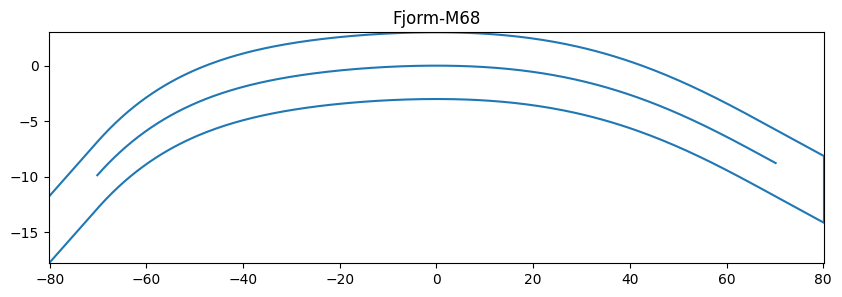

In [23]:
windows = {}
for name, gs_name in streams.items():
    gs = mws[gs_name]
    
    track = gs.track.transform_to(gs.stream_frame)
    
    if name == 'Pal5':
        # extrapolation of the track went wonky for pal 5
        spl = InterpolatedUnivariateSpline(
            track.phi1.degree[20:-10],
            track.phi2.degree[20:-10],
            k=1
        )
    else:
        spl = InterpolatedUnivariateSpline(
            track.phi1.degree,
            track.phi2.degree,
            k=1
        )
    
    if name == 'GD-1':
        grid_phi1 = np.linspace(-100, 20, 256)
    else:
        # extend track by +/- 5 deg in phi1:
        grid_phi1 = np.linspace(
            track.phi1.degree.min() - 10,
            track.phi1.degree.max() + 10,
            256
        )
    grid_phi2 = spl(grid_phi1)
    
    phi1 = np.concatenate((
        grid_phi1,
        grid_phi1[::-1],
    ))
    phi2 = np.concatenate((
        grid_phi2 - 3 * stds[name],
        grid_phi2[::-1] + 3 * stds[name],
    ))
    
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(
        track.phi1.degree,
        track.phi2.degree
    )
    ax.plot(
        phi1,
        phi2,
        color='tab:blue'
    )
    ax.set_title(name)
    
    windows[name] = [(phi1.min(), phi1.max()), (phi2.min(), phi2.max())]
    ax.set_xlim(windows[name][0])
    ax.set_ylim(windows[name][1])

## Run queries

In [25]:
dphi1 = 10.
for name, gs_name in streams.items():
    gs = mws[gs_name]
    
    this_path = data_path / name
    this_path.mkdir(exist_ok=True)
    
    phi1_lim, phi2_lim = windows[name]
    
    phi1_grid = np.clip(np.arange(phi1_lim[0], phi1_lim[1]+dphi1, dphi1), phi1_lim[0], phi1_lim[1])

    _jobs = {}
    for i, (l, r) in enumerate(zip(phi1_grid[:-1], phi1_grid[1:])):
        filename = this_path / f'poly_{i:02d}.fits'
        jobname = f'{name}_{i:02d}'

        print(i, l, r, filename, jobname)

        if filename.exists():
            continue

        elif not filename.exists() and jobname in jobs:
            # TODO: download job and save file
            pass

        else:
            corners = coord.SkyCoord(
                phi1=[l, l, r, r] * u.deg, 
                phi2=[phi2_lim[0], phi2_lim[1], phi2_lim[1], phi2_lim[0]] * u.deg,
                frame=gs.stream_frame
            ).icrs

            query = base_query.format(
                columns=', '.join(gaia_columns), 
                c=corners
            )

            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                job = Gaia.launch_job_async(query, name=jobname, background=True)
            _jobs[filename] = job

    if _jobs:
        for fn, job in _jobs.items():
            tbl = job.get_results()
            tbl.write(fn, overwrite=True)

0 -80.141963010425 -70.141963010425 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_00.fits Fjorm-M68_00


        Use @ instead. [gala.coordinates.greatcircle]


1 -70.141963010425 -60.141963010425 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_01.fits Fjorm-M68_01


        Use @ instead. [gala.coordinates.greatcircle]


2 -60.141963010425 -50.141963010425 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_02.fits Fjorm-M68_02


        Use @ instead. [gala.coordinates.greatcircle]


3 -50.141963010425 -40.141963010425 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_03.fits Fjorm-M68_03


        Use @ instead. [gala.coordinates.greatcircle]


4 -40.141963010425 -30.141963010425002 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_04.fits Fjorm-M68_04


        Use @ instead. [gala.coordinates.greatcircle]


5 -30.141963010425002 -20.141963010425002 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_05.fits Fjorm-M68_05


        Use @ instead. [gala.coordinates.greatcircle]


6 -20.141963010425002 -10.141963010425002 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_06.fits Fjorm-M68_06


        Use @ instead. [gala.coordinates.greatcircle]


7 -10.141963010425002 -0.1419630104250018 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_07.fits Fjorm-M68_07


        Use @ instead. [gala.coordinates.greatcircle]


8 -0.1419630104250018 9.858036989574998 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_08.fits Fjorm-M68_08


        Use @ instead. [gala.coordinates.greatcircle]


9 9.858036989574998 19.858036989574998 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_09.fits Fjorm-M68_09


        Use @ instead. [gala.coordinates.greatcircle]


10 19.858036989574998 29.858036989574998 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_10.fits Fjorm-M68_10


        Use @ instead. [gala.coordinates.greatcircle]


11 29.858036989574998 39.858036989575 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_11.fits Fjorm-M68_11


        Use @ instead. [gala.coordinates.greatcircle]


12 39.858036989575 49.858036989575 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_12.fits Fjorm-M68_12


        Use @ instead. [gala.coordinates.greatcircle]


13 49.858036989575 59.858036989575 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_13.fits Fjorm-M68_13


        Use @ instead. [gala.coordinates.greatcircle]


14 59.858036989575 69.858036989575 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_14.fits Fjorm-M68_14


        Use @ instead. [gala.coordinates.greatcircle]


15 69.858036989575 79.858036989575 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_15.fits Fjorm-M68_15


        Use @ instead. [gala.coordinates.greatcircle]


16 79.858036989575 80.14351946937923 /Users/Tavangar/Work/CATS_Workshop/cats/data/Fjorm-M68/poly_16.fits Fjorm-M68_16


        Use @ instead. [gala.coordinates.greatcircle]


## Combine tables

In [4]:
from numpy.lib.recfunctions import stack_arrays

        Use @ instead. [gala.coordinates.greatcircle]


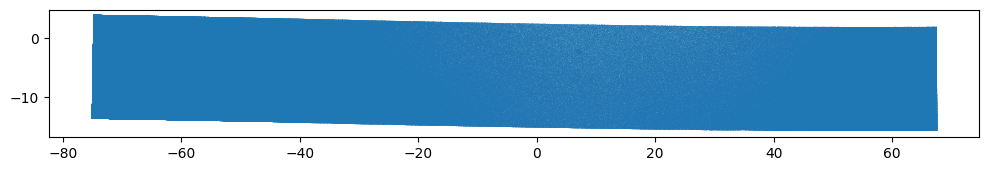

In [7]:
for name, gs_name in streams.items():
    gs = mws[gs_name]
    
    this_path = data_path / name
    
    all_filename = pathlib.Path(data_path / f'GaiaDR3-{name}-all.fits')
    if all_filename.exists():
        continue
    
    arrs = []
    for filename in this_path.glob('poly_*.fits'):
        arrs.append(np.array(fits.getdata(filename)))
    arr = stack_arrays(arrs, asrecarray=True, usemask=False)
    
    t = at.Table(arr)
    t = at.unique(t, keys='source_id')
    
    c = coord.SkyCoord(
        t['ra'] * u.deg,
        t['dec'] * u.deg,
    ).transform_to(gs.stream_frame)
    t['phi1'] = c.phi1.degree
    t['phi2'] = c.phi2.degree
    
    t.write(all_filename, overwrite=True)
    
    # ---
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(
        c.phi1.wrap_at(180*u.deg),
        c.phi2, 
        marker=',', linestyle='none', alpha=0.05
    )
    ax.set_aspect('equal')

In [28]:
tbl = at.Table.read(data_path / 'GaiaDR3-Fjorm-M68-all.fits')
len(tbl)

18395799

In [31]:
sub_tbl = tbl['source_id', 'ra', 'dec']
path = data_path / 'tmp'
path.mkdir(exist_ok=True)

idx = np.linspace(0, len(tbl), 2).astype(int)
for j, (i1, i2) in enumerate(zip(idx[:-1], idx[1:])):
    sub_tbl[i1:i2].write(
        path / f'fjorm-M68_all_mast_upload{j}.xml', 
        overwrite=True,
        format='votable'
    )

## MAST XM Input

In [2]:
'''
select s.source_id, s.ra, s.dec, o.objID, o.raMean, o.decMean,
   o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
   m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag,
   m.gMeanPSFMagErr, m.rMeanPSFMagErr, m.iMeanPSFMagErr, m.zMeanPSFMagErr, m.yMeanPSFMagErr,
   m.iMeanKronMag
into mydb.Fjorm_M68_DR3_xm_1 
from MyDB.mast_subset_Fjorm_M68_1 s
cross apply fGetNearbyObjEq(s.ra, s.dec, 3.0 / 60.0) nb
inner join ObjectThin o on o.objid=nb.objid and o.nDetections>3
inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid
'''

'\nselect s.source_id, s.ra, s.dec, o.objID, o.raMean, o.decMean,\n   o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,\n   m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag,\n   m.gMeanPSFMagErr, m.rMeanPSFMagErr, m.iMeanPSFMagErr, m.zMeanPSFMagErr, m.yMeanPSFMagErr,\n   m.iMeanKronMag\ninto mydb.Pal5_DR3_xm_extra \nfrom MyDB.pal5_all_mast_upload s\ncross apply fGetNearbyObjEq(s.ra, s.dec, 3.0 / 60.0) nb\ninner join ObjectThin o on o.objid=nb.objid and o.nDetections>3\ninner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid\n'

## Joining the Tables

In [8]:
ps1 = at.Table.read(data_path / 'tmp/Pal5_DR3_PS1_xm_ktavangar.fit')
for col in ps1.colnames:
    ps1[col] = ps1[col][:, 0]

In [11]:
len(tbl), len(ps1)

(2956799, 3086921)

In [12]:
joined = at.join(
    tbl, 
    ps1, 
    keys='source_id', 
    uniq_col_name='{col_name}{table_name}', 
    table_names=['', '_2']
)
joined['index'] = np.arange(len(joined), dtype=int)

In [13]:
np.unique(ps1['source_id']).size, np.unique(ps1['objID']).size

(2954577, 3054867)

In [14]:
gaia_c = coord.SkyCoord(joined['ra'], joined['dec'], unit='deg')
ps1_c = coord.SkyCoord(joined['raMean'], joined['decMean'], unit='deg')
sep = gaia_c.separation(ps1_c)
joined['sep_arcsec'] = sep.to_value(u.arcsec)
sep_mask = (
    (sep < 1*u.arcsec) &  # seems I can be stricter
    (joined['ng'] > 2) &  # helps trim PS1 duplicate sources
    (joined['nr'] > 2) & 
    (joined['ni'] > 2)
)

In [15]:
vals, counts = np.unique(joined['source_id'][sep_mask], return_counts=True)
dup_mask = np.isin(joined['source_id'], vals[counts > 1])
dup_mask.sum()

7276

In [16]:
tmp = joined[dup_mask]
del_index = []
for source_id in tqdm(np.unique(tmp['source_id'])):
    rows = tmp[tmp['source_id'] == source_id]
    closest_i = rows['sep_arcsec'].argmin()
    shit = np.asarray(rows['index'][rows['index'] != rows['index'][closest_i]])
    del_index = np.concatenate((del_index, shit))

100%|██████████| 3292/3292 [00:02<00:00, 1152.24it/s]


In [17]:
cleaned = joined[sep_mask & (~np.isin(joined['index'], del_index))]
len(joined), len(cleaned)

(3086921, 2857497)

In [18]:
vals, counts = np.unique(cleaned['objID'], return_counts=True)
dup_mask_ps1 = np.isin(cleaned['objID'], vals[counts > 1])
dup_mask_ps1.sum()


1050

In [19]:
write_colnames = ps1.colnames + ['sep_arcsec']
write_colnames.pop(1)
write_colnames.pop(1)
cleaned[write_colnames].write(data_path / 'PS1DR2_Pal5_xm.fits', overwrite=True)

In [23]:
import sys
sys.path.append('../')
import cats.photometry as phot
from cats.data import make_astro_photo_joined_data

name = 'Pal5'
ms_name = 'Pal5-PW19'
g = GaiaData(f'../data/GaiaDR3-{name}-all.fits')
p = phot.PS1Phot(f'../data/PS1DR2_Pal5_xm.fits')
gs = mws[ms_name]

In [24]:
joined = make_astro_photo_joined_data(g, p, gs)
joined.write(f'../data/joined-{name}_version2.fits', overwrite=True)

        Use @ instead. [gala.coordinates.greatcircle]


In [25]:
joined

source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_flux_over_error,ruwe,astrometric_matched_transits,phi1,phi2,pm_phi1_cosphi2,pm_phi1_cosphi2_unrefl,pm_phi2,pm_phi2_unrefl,star_mask,g0,r0,i0,z0,y0
,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,
int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64
1152921642046057600,225.01725207664146,0.031173074881935294,0.5274778604021236,0.16501048,-14.205774967883292,0.16504936,0.6693334057213256,0.14581224,-0.41641617,0.055257276,-0.1417481,-0.45241204,-0.100705795,0.09009205,-0.019543147,0.08448724,-0.10846218,17.96442,626.61804,18.468573,37.74546,17.329996,120.687935,0.9961293,21,3.2375585184719298,-2.336727347320985,8.945967190022602,11.48528982856014,-9.01349761674976,-8.386904506439029,True,18.413771465420723,17.812169209122658,17.569516874849796,17.46965292841196,17.388298258185387
1152921646341528576,225.0298806737716,0.02963058150960117,0.25842142442320365,0.06763306,-6.326358236944066,0.08140472,-10.369505161283758,0.07046268,-0.19756061,0.032141022,-0.10863238,-0.16480868,-0.09749578,0.12153087,0.0068655154,0.06949286,-0.035844613,16.730392,1167.1216,17.031622,158.0333,16.262787,200.7755,1.1415453,24,3.2278624864547805,-2.3284809296626894,8.454418925996075,10.993443441072735,4.5400767733076,5.166589507593525,True,16.865407824516296,16.61016371846199,16.522174775600433,16.5005347058177,16.488825473934412
1152921676405542912,225.02856508375135,0.03255618855271846,0.19289056329088083,0.20087536,-7.534899641443221,0.23768133,3.708972830079383,0.19803469,-0.3015835,0.09661818,-0.04246375,-0.22465621,-0.017594278,0.058393944,-0.13223656,-0.006926631,-0.019965878,18.626148,457.3165,18.937263,26.264584,18.091547,87.383965,0.9865868,23,3.227347631142805,-2.3316472074961054,1.7046028331324057,4.243611522783629,-7.873776608628671,-7.247272128503684,True,18.848761692643166,18.480545952916145,18.350409127771854,18.301440462470055,18.282111708074808
1152921715061005696,225.00625684093683,0.042436471397097976,0.40067190664822405,0.038644496,-8.7938419565765,0.041019402,-1.015930940108139,0.036344964,-0.26211518,0.06649366,-0.119367905,-0.32218683,-0.036483526,0.0007180708,-0.14845128,0.13129467,-0.18826331,15.597105,2511.0989,16.033615,372.93732,14.994933,454.55008,1.0154525,23,3.24052917661327,-2.352185329614114,5.358544878332198,7.897958901290051,-4.62485531507119,-3.9982517711929497,True,15.928808853030205,15.450484231114388,15.270890176296234,15.20121806114912,15.148926921188831
1152921745125274112,225.0212570363653,0.05483142064503818,0.29013617460026675,0.1422265,-11.541753464165701,0.15958185,-3.0606442797759397,0.13177453,-0.2922285,0.0083756875,-0.11353354,-0.15684058,-0.10813976,0.01685879,-0.14496961,-0.022294477,-0.09564096,18.038414,587.34534,18.34814,46.078896,17.60992,45.462753,1.0379219,22,3.2211653087843723,-2.3542621639910655,8.778887512287724,11.3177062121297,-4.4328828931609054,-3.8064606304054895,True,18.16034634411335,17.91790822148323,17.84269604831934,17.82655967772007,17.808221373707056
1152921882564226432,224.9751807626325,0.041226769944577066,0.13522485716411534,0.42181966,-2.950958298624454,0.54853165,-0.21953179024319838,0.39976043,-0.14534795,-0.10673351,-0.18171288,-0.30191985,-0.09828016,-0.13539705,-0.31086498,0.078059606,-0.02208467,19.620945,232.62732,20.593409,6.463786,18.547794,18.405022,0.9522293,21,3.267150285389646,-2.3683006637908584,0.0432280584342317,2.5834614757091634,-2.0697725199033195,-1.4429400